In [1]:
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import time
import pandas as pd
from tqdm import tqdm
import pymysql
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [2]:
plt.style.use("ggplot")

In [3]:
plt.rcParams['font.family'] = 'Malgun Gothic'

In [4]:
db = pymysql.connect(
    host='192.168.0.109',
    port=3306,
    user='root',
    passwd='1234',
    db='coin_db',
    charset='utf8'
)

In [5]:
sql = "SELECT open_time as ds, close_price as y FROM coin_tbl WHERE open_time > '2023-10-04 00:00:00';"

In [6]:
bitcoin_df = pd.read_sql(sql, db)

C:\Users\tjk\AppData\Local\Temp\ipykernel_13468\1041689760.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bitcoin_df = pd.read_sql(sql, db)


In [7]:
bitcoin_df

,ds,y
0,2023-10-04 10:14:00,27344.83
1,2023-10-04 10:15:00,27346.71
2,2023-10-04 10:16:00,27339.07
3,2023-10-04 10:17:00,27291.56
4,2023-10-04 10:18:00,27285.97
...,...,...
342,2023-10-04 15:56:00,NaN
343,2023-10-04 15:57:00,NaN
344,2023-10-04 15:58:00,NaN
345,2023-10-04 15:59:00,NaN


In [8]:
bitcoin_df.shape

(347, 2)

In [9]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      347 non-null    datetime64[ns]
 1   y       287 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.5 KB


In [10]:
bitcoin_df.set_index('ds', inplace=True)

In [11]:
bitcoin_df.describe()

,y
count,287.000000
mean,27394.606063
std,44.778595
min,27260.810000
25%,27379.095000
50%,27404.610000
75%,27422.180000
max,27495.650000


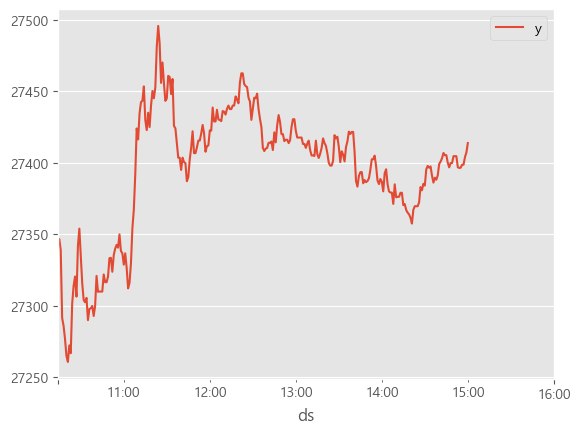

In [12]:
bitcoin_df.plot()
plt.show()

In [13]:
bitcoin_df.reset_index(inplace=True)

In [14]:
bitcoin_df

,ds,y
0,2023-10-04 10:14:00,27344.83
1,2023-10-04 10:15:00,27346.71
2,2023-10-04 10:16:00,27339.07
3,2023-10-04 10:17:00,27291.56
4,2023-10-04 10:18:00,27285.97
...,...,...
342,2023-10-04 15:56:00,NaN
343,2023-10-04 15:57:00,NaN
344,2023-10-04 15:58:00,NaN
345,2023-10-04 15:59:00,NaN


In [15]:
prophet = Prophet(
    seasonality_mode='multiplicative', # 트렌드 반영
    yearly_seasonality=True, # 연간 트렌드 반영
    weekly_seasonality=True, # 주간 트렌드 반영
    daily_seasonality=True, # 일간 트렌드 반영
    changepoint_prior_scale=0.5 # 트렌드 반영 비율
)

In [16]:
prophet.fit(bitcoin_df)

15:28:37 - cmdstanpy - INFO - Chain [1] start processing
15:28:38 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# 1분에 60개의 데이터를 예측하도록 설정
future_data = prophet.make_future_dataframe(periods=60, freq='min')

In [18]:
forecast_data = prophet.predict(future_data)

In [19]:
forecast_data.tail(60)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
347,2023-10-04 16:01:00,22935.960129,25925.976707,27512.410251,22287.496300,23638.107454,0.119116,0.119116,0.119116,0.163435,...,0.005992,0.005992,0.005992,0.038327,0.038327,0.038327,0.0,0.0,0.0,26684.489513
348,2023-10-04 16:02:00,22904.128202,25883.178698,27506.724204,22229.576039,23623.568546,0.119617,0.119617,0.119617,0.163915,...,0.005971,0.005971,0.005971,0.038326,0.038326,0.038326,0.0,0.0,0.0,26658.455696
349,2023-10-04 16:03:00,22872.296276,25829.851281,27483.213264,22191.836181,23606.446983,0.120096,0.120096,0.120096,0.164373,...,0.005951,0.005951,0.005951,0.038326,0.038326,0.038326,0.0,0.0,0.0,26631.876386
350,2023-10-04 16:04:00,22840.464350,25787.393454,27477.852207,22146.597985,23591.127183,0.120552,0.120552,0.120552,0.164808,...,0.005930,0.005930,0.005930,0.038326,0.038326,0.038326,0.0,0.0,0.0,26604.749536
351,2023-10-04 16:05:00,22808.632423,25742.689692,27473.376052,22085.965490,23573.566489,0.120985,0.120985,0.120985,0.165220,...,0.005909,0.005909,0.005909,0.038326,0.038326,0.038326,0.0,0.0,0.0,26577.073239
352,2023-10-04 16:06:00,22776.800497,25687.487634,27463.364712,22040.839290,23557.430035,0.121396,0.121396,0.121396,0.165609,...,0.005888,0.005888,0.005888,0.038325,0.038325,0.038325,0.0,0.0,0.0,26548.845721
353,2023-10-04 16:07:00,22744.968570,25642.268071,27463.440899,21995.687650,23547.079307,0.121783,0.121783,0.121783,0.165975,...,0.005867,0.005867,0.005867,0.038325,0.038325,0.038325,0.0,0.0,0.0,26520.065350
354,2023-10-04 16:08:00,22713.136644,25605.717208,27446.195829,21944.643150,23534.551028,0.122146,0.122146,0.122146,0.166318,...,0.005846,0.005846,0.005846,0.038325,0.038325,0.038325,0.0,0.0,0.0,26490.730631
355,2023-10-04 16:09:00,22681.304717,25540.267317,27448.189667,21891.717873,23521.613553,0.122486,0.122486,0.122486,0.166637,...,0.005825,0.005825,0.005825,0.038325,0.038325,0.038325,0.0,0.0,0.0,26460.840209
356,2023-10-04 16:10:00,22649.472791,25488.448367,27429.280463,21843.912817,23506.392464,0.122803,0.122803,0.122803,0.166932,...,0.005805,0.005805,0.005805,0.038324,0.038324,0.038324,0.0,0.0,0.0,26430.392867


In [20]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(60)

,ds,yhat,yhat_lower,yhat_upper
347,2023-10-04 16:01:00,26684.489513,25925.976707,27512.410251
348,2023-10-04 16:02:00,26658.455696,25883.178698,27506.724204
349,2023-10-04 16:03:00,26631.876386,25829.851281,27483.213264
350,2023-10-04 16:04:00,26604.749536,25787.393454,27477.852207
351,2023-10-04 16:05:00,26577.073239,25742.689692,27473.376052
352,2023-10-04 16:06:00,26548.845721,25687.487634,27463.364712
353,2023-10-04 16:07:00,26520.065350,25642.268071,27463.440899
354,2023-10-04 16:08:00,26490.730631,25605.717208,27446.195829
355,2023-10-04 16:09:00,26460.840209,25540.267317,27448.189667
356,2023-10-04 16:10:00,26430.392867,25488.448367,27429.280463


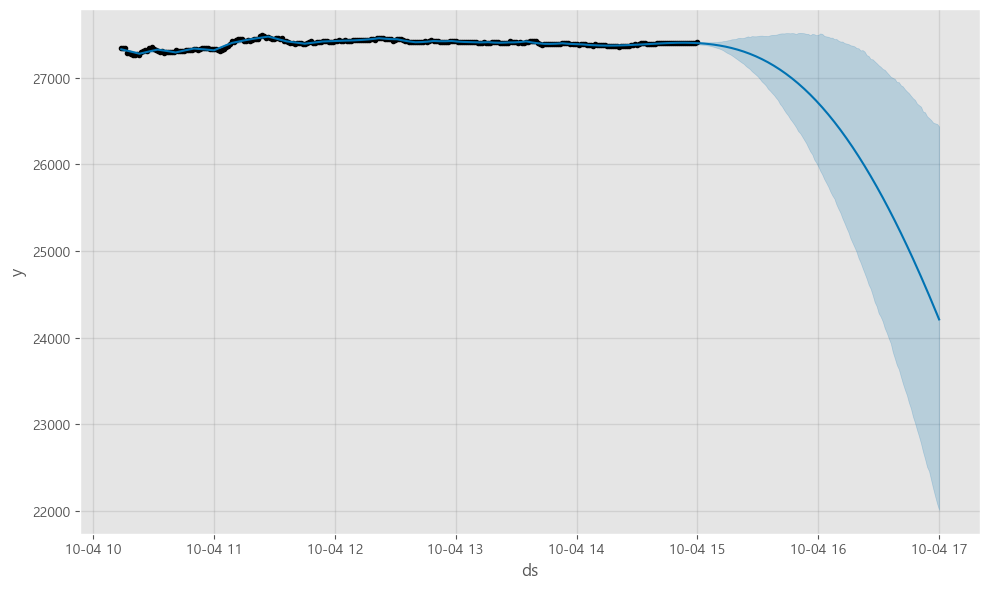

In [21]:
fig1 = prophet.plot(forecast_data)

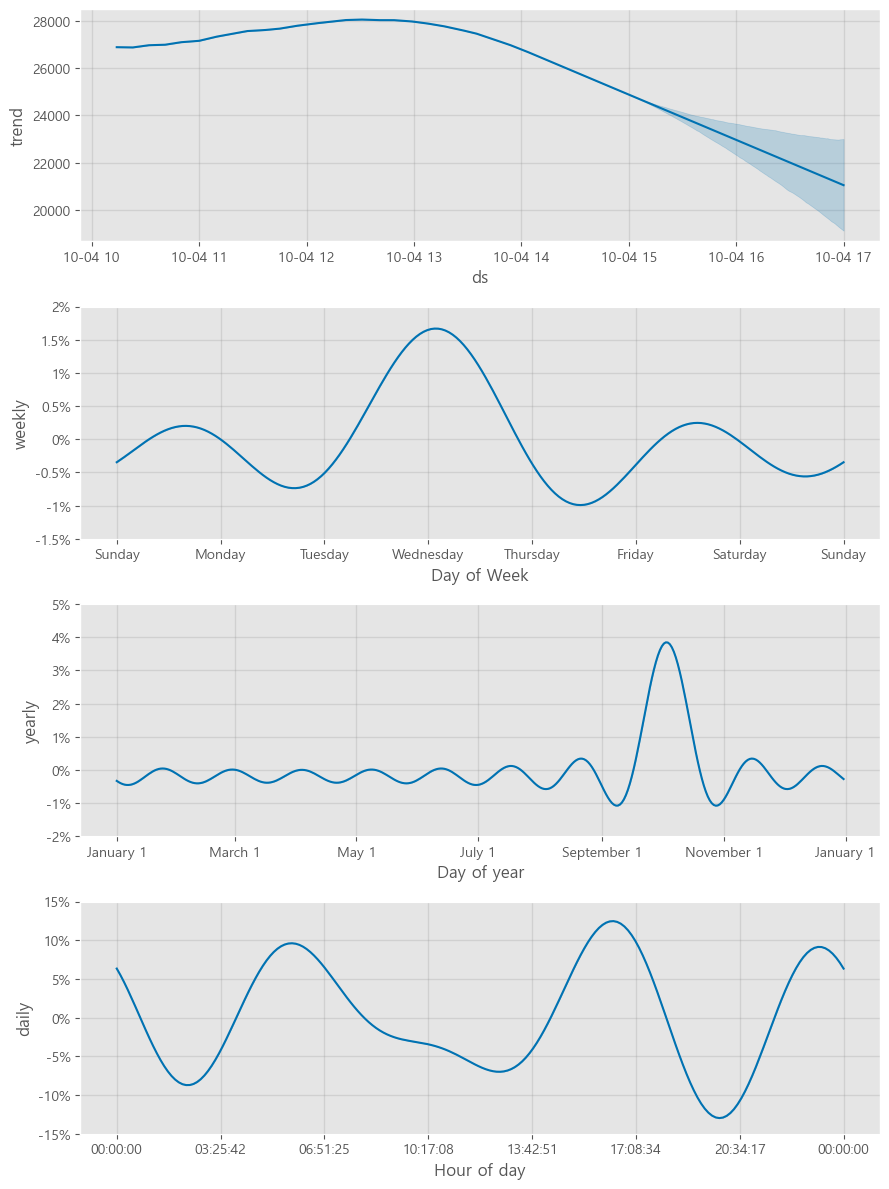

In [22]:
fig2 = prophet.plot_components(forecast_data)

In [23]:
pred_y = forecast_data.yhat.values
test_y = bitcoin_df.y.values
pred_y_lower = forecast_data.yhat_lower.values
pred_y_upper = forecast_data.yhat_upper.values

In [24]:
rmse = sqrt(mean_squared_error(test_y, pred_y[:-60]))
print(rmse)

ValueError: Input contains NaN.

In [ ]:
r2_score(test_y, pred_y[:-60])

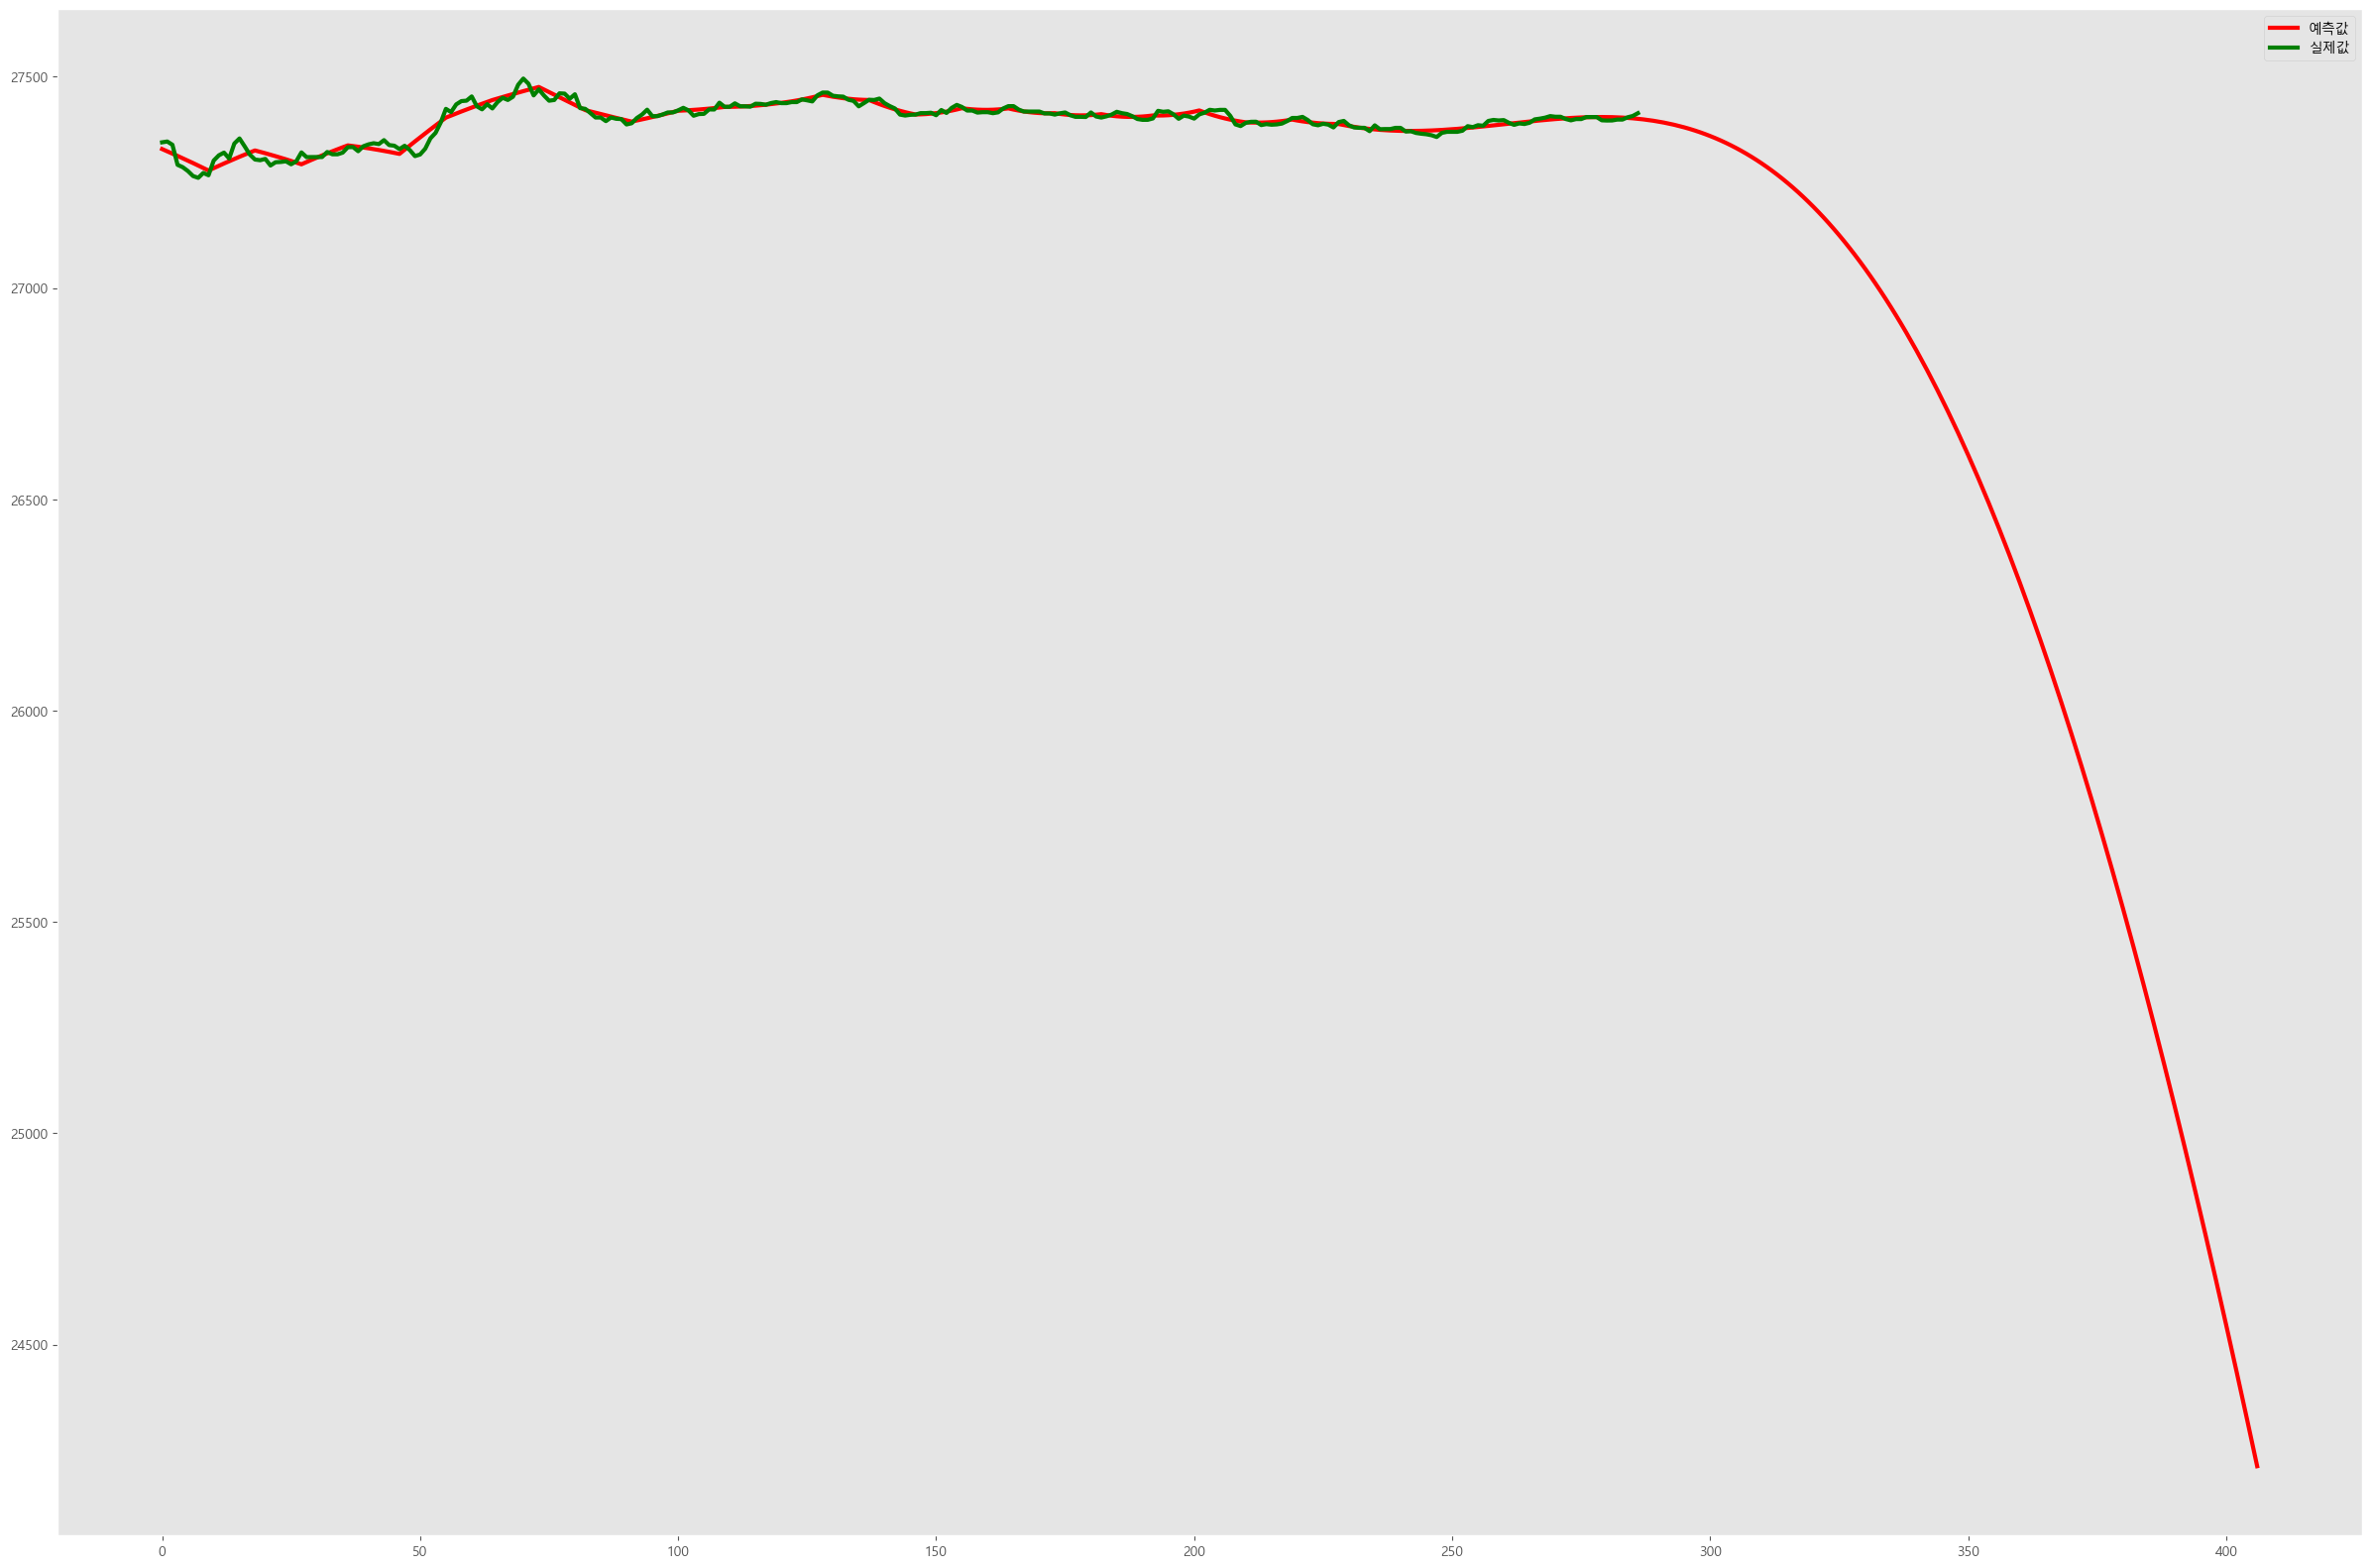

In [25]:
plt.figure(figsize=(30, 20))
plt.plot(pred_y, color='red', label="예측값", lw=3.0)
plt.plot(test_y, color='green', label="실제값", lw=3.0)
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(30, 20))
plt.plot(pred_y, color='red', label="예측값", lw=3.0)
plt.plot(test_y, color='green', label="실제값", lw=3.0)
plt.plot(pred_y_lower, color='blue', label="예측값 하한선", alpha=0.5)
plt.plot(pred_y_upper, color='purple', label="예측값 상한선", alpha=0.5)
plt.legend()
plt.grid()
plt.show()

In [ ]:
len(bitcoin_df)

In [ ]:
df_count = len(bitcoin_df)

In [ ]:
cursor = db.cursor()

In [ ]:
for index in range(df_count):
    open_date = bitcoin_df.loc[index, 'ds']
    print("open_date =", open_date)
    predict_price = forecast_data.loc[index, 'yhat']
    print("predict_price =", predict_price)
    
    sql = "UPDATE coin_tbl SET predic_price=%s WHERE open_time=%s"
    
    cursor.execute(sql, (predict_price, open_date))
    db.commit()
    print("=" * 100)

In [ ]:
db.close()